In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

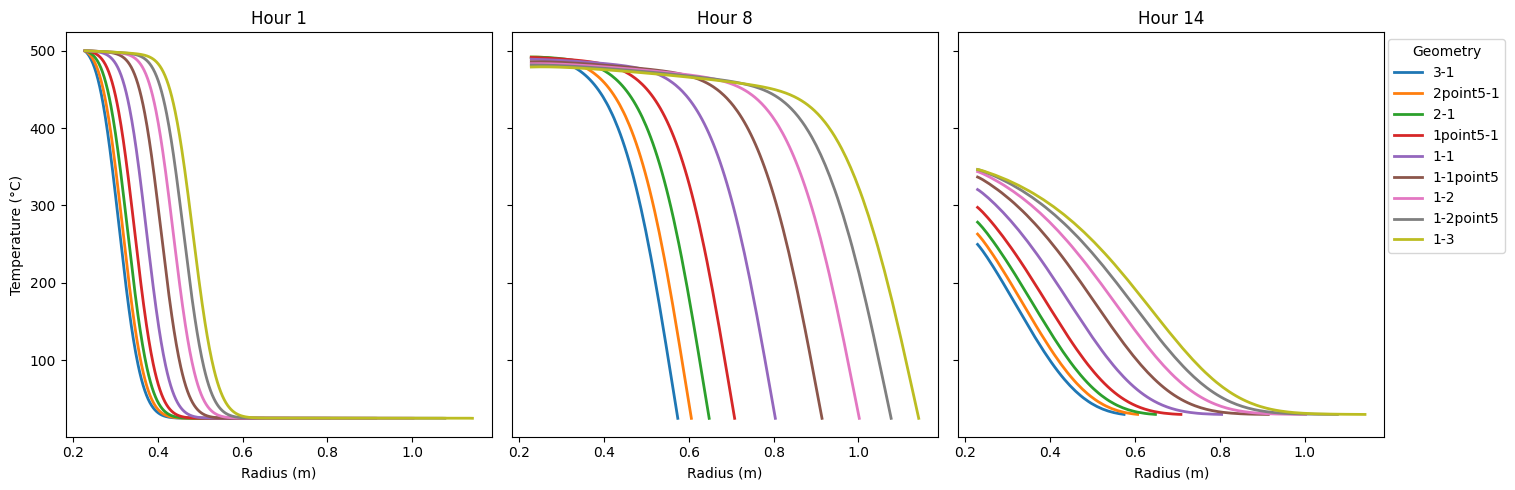

In [4]:

BASE_DIR   = r"C:\Users\tljohn\Desktop\RPB Micmaq\geometry simulations\final"
PROFILES   = "thermocline_profiles.csv"

#——— manually list exactly the geometries you have ———
SUBDIRS = [
    "3-1",
    "2point5-1",
    "2-1",
    "1point5-1",
    "1-1",
    "1-1point5",
    "1-2",
    "1-2point5",
    "1-3",
]

# which hours/phases to snapshot?
TRACE_HOURS = [1, 8, 14]
PHASE_IDX   = [h-1 for h in TRACE_HOURS]

# pick a distinct color for each
palette = plt.get_cmap("tab10")
colors  = {geo: palette(i%10) for i, geo in enumerate(SUBDIRS)}

# load all CSVs
all_data = {}
for geo in SUBDIRS:
    path = os.path.join(BASE_DIR, geo, PROFILES)
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing {PROFILES} in folder {geo}")
    all_data[geo] = pd.read_csv(path)

# build 1×3 panel
fig, axs = plt.subplots(1, len(TRACE_HOURS), figsize=(5*len(TRACE_HOURS),5), sharey=True)

for ax, hour, phase in zip(axs, TRACE_HOURS, PHASE_IDX):
    for geo, df in all_data.items():
        dfp = df[df["Phase"] == phase]
        ax.plot(dfp["Radius_m"], dfp["Temperature_C"],
                color=colors[geo], lw=2, label=geo)
    ax.set_title(f"Hour {hour}")
    ax.set_xlabel("Radius (m)")

axs[0].set_ylabel("Temperature (°C)")
axs[-1].legend(title="Geometry", loc="upper right", bbox_to_anchor=(1.3,1))
plt.tight_layout()
plt.show()


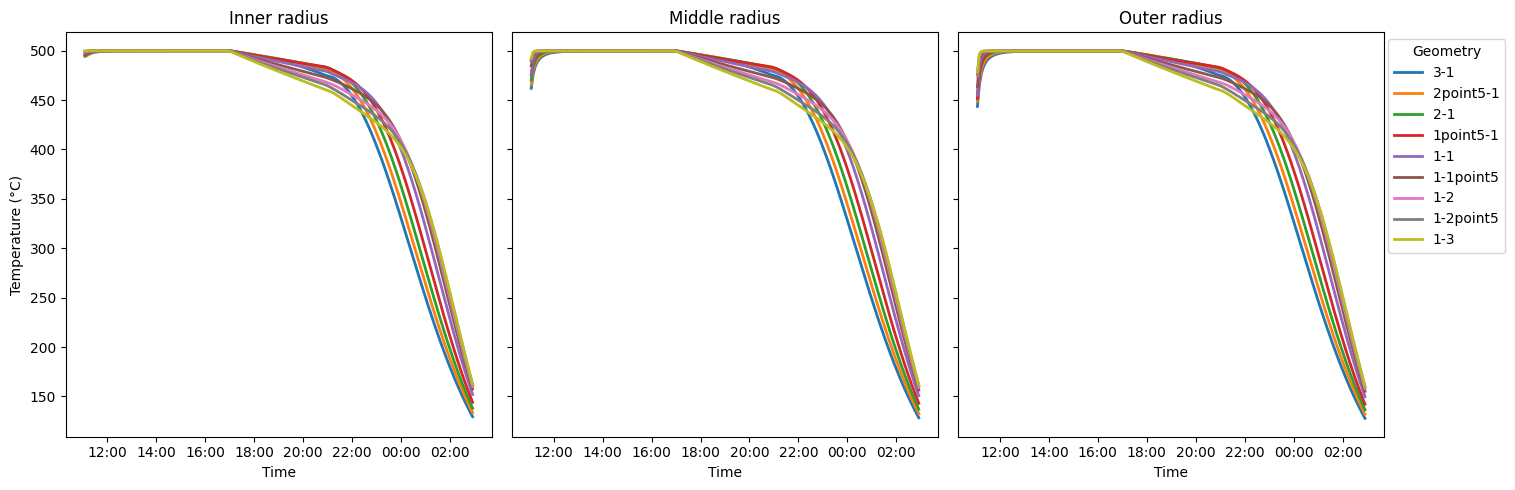

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# ── CONFIG ─────────────────────────────────────────────────────────────────
BASE_DIR    = r"C:\Users\tljohn\Desktop\RPB Micmaq\geometry simulations\final"
GEOMETRIES = [
    "3-1",
    "2point5-1",
    "2-1",
    "1point5-1",
    "1-1",
    "1-1point5",
    "1-2",
    "1-2point5",
    "1-3",
]
HISTORY_CSV = "thermocline_timehistory.csv"

# anchor time for plotting
BASE_TIME   = datetime(2033,3,20,11,0,0)

# specify exactly which Ts_r columns are your inner / middle / outer nodes
INNER_COL  = "Ts_r0"   # most‐inner
MIDDLE_COL = "Ts_r6"   # midpoint (for a 12‐node grid)
OUTER_COL  = "Ts_r11"  # outermost

# ── SET UP FIGURE ───────────────────────────────────────────────────────────
fig, axs = plt.subplots(1,3, figsize=(15,5), sharey=True)
for ax, title in zip(axs, ("Inner radius","Middle radius","Outer radius")):
    ax.set_title(title)
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    # ax.grid(True)

axs[0].set_ylabel("Temperature (°C)")

# ── LOOP OVER GEOMETRIES ────────────────────────────────────────────────────
for i, geom in enumerate(GEOMETRIES):
    fn = os.path.join(BASE_DIR, geom, HISTORY_CSV)
    if not os.path.exists(fn):
        print(f"skipping {geom!r} (no file)")
        continue

    df = pd.read_csv(fn)
    df = df[df["time_sec"]>0].copy()
    df["time_dt"] = df["time_sec"].apply(
        lambda s: BASE_TIME + timedelta(seconds=s)
    )

    # pull out the three columns
    for ax, col in zip(axs, (INNER_COL, MIDDLE_COL, OUTER_COL)):
        ax.plot(
            df["time_dt"],
            df[col] - 273.15,      # if your Ts are in K; otherwise drop the “- 273.15”
            lw=2,
            label=geom
        )

# ── FINISH UP ───────────────────────────────────────────────────────────────
axs[-1].legend(title="Geometry", loc="upper right", bbox_to_anchor=(1.3,1))
for ax in axs:
    ax.set_xlabel("Time")

plt.tight_layout()
plt.show()


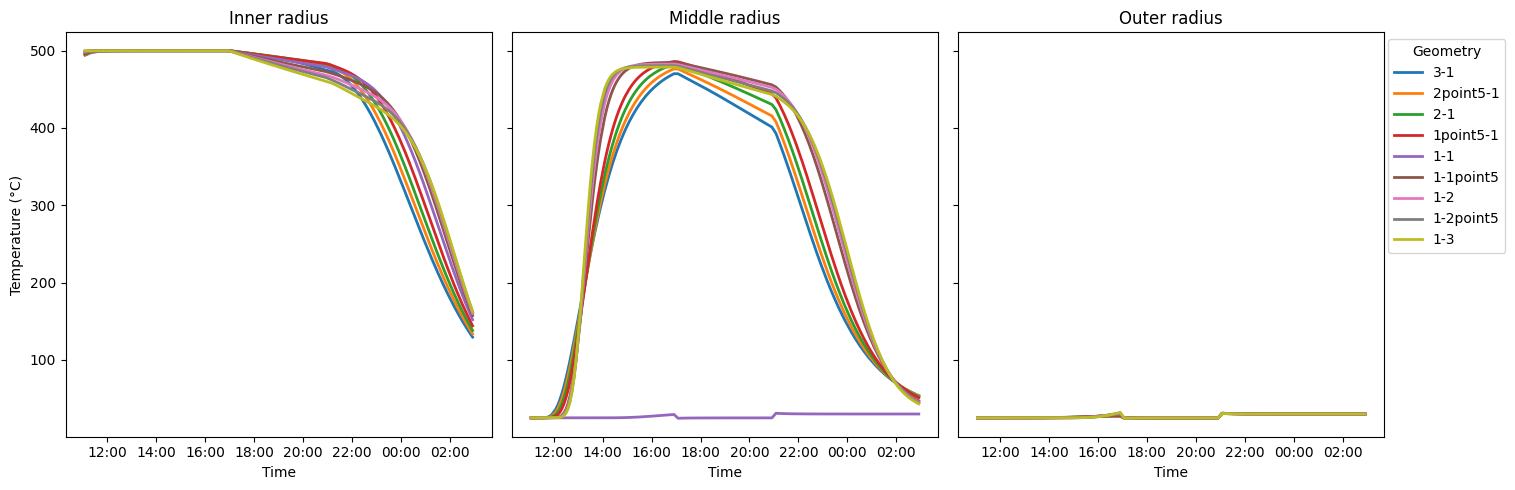

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# ── CONFIG ─────────────────────────────────────────────────────────────────
BASE_DIR    = r"C:\Users\tljohn\Desktop\RPB Micmaq\geometry simulations\final"
GEOMETRIES  = [
    "3-1",
    "2point5-1",
    "2-1",
    "1point5-1",
    "1-1",
    "1-1point5",
    "1-2",
    "1-2point5",
    "1-3",
]
HISTORY_CSV = "thermocline_timehistory.csv"

# anchor time for plotting
BASE_TIME   = datetime(2033,3,20,11,0,0)

# ── HELPERS ─────────────────────────────────────────────────────────────────
def parse_geom(geom):
    """From a folder name like '1-2point5' return (r_inner, r_outer) as floats."""
    left, right = geom.split("-", 1)
    def to_f(s): return float(s.replace("point", "."))
    ri, ro = to_f(left), to_f(right)
    # just in case someone put them backwards:
    return (ri, ro) if ri <= ro else (ro, ri)

# ── SET UP FIGURE ───────────────────────────────────────────────────────────
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for ax, title in zip(axs, ("Inner radius", "Middle radius", "Outer radius")):
    ax.set_title(title)
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
axs[0].set_ylabel("Temperature (°C)")

# ── LOOP OVER GEOMETRIES ────────────────────────────────────────────────────
for geom in GEOMETRIES:
    fn = os.path.join(BASE_DIR, geom, HISTORY_CSV)
    if not os.path.exists(fn):
        print(f"skipping {geom!r} (no file)"); continue

    # load and stamp with actual datetimes
    df = pd.read_csv(fn)
    df = df[df["time_sec"] > 0].copy()
    df["time_dt"] = df["time_sec"].apply(
        lambda s: BASE_TIME + timedelta(seconds=s)
    )

    # find all the Ts_r* columns in order
    Ts_cols = sorted(
        [c for c in df.columns if c.startswith("Ts_r")],
        key=lambda c: int(c.split("Ts_r")[1])
    )
    # parse the true inner/outer radii for this geometry
    r_inner, r_outer = parse_geom(geom)
    # build the nodal‐radius array
    N = len(Ts_cols)
    r_nodes = np.linspace(r_inner, r_outer, N)
    # true midpoint
    r_mid = 0.5 * (r_inner + r_outer)

    # grab the data as a (time × N) array
    Ts_array = df[Ts_cols].values  # shape (n_time, N)

    # interpolate
    Ts_inner = Ts_array[:,  0]                                        # at r_inner
    Ts_mid   = np.apply_along_axis(lambda y: np.interp(r_mid, r_nodes, y), 1, Ts_array)
    Ts_outer = Ts_array[:, -1]                                        # at r_outer

    # plot each on its own axis
    for ax, series in zip(axs, (Ts_inner, Ts_mid, Ts_outer)):
        ax.plot(df["time_dt"],
                series - 273.15,    # drop 273.15 if your CSV is already in °C
                lw=2,
                label=geom)

# ── FINISH UP ───────────────────────────────────────────────────────────────
axs[-1].legend(title="Geometry", loc="upper right", bbox_to_anchor=(1.3,1))
for ax in axs:
    ax.set_xlabel("Time")

plt.tight_layout()
plt.show()


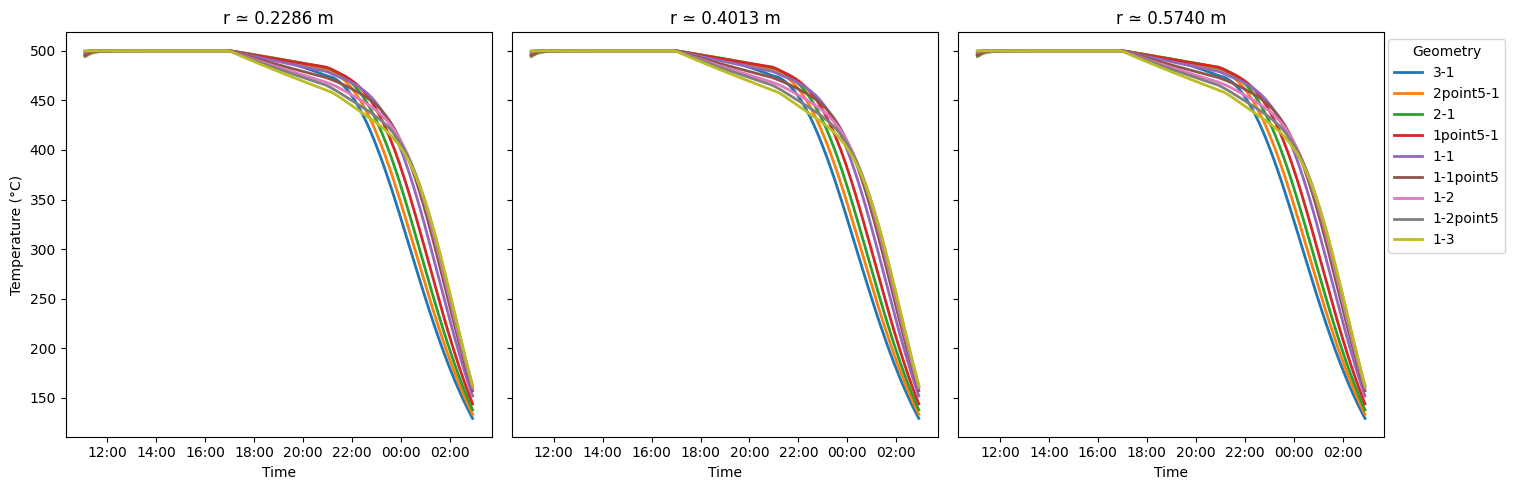

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# ── CONFIG ─────────────────────────────────────────────────────────────────
BASE_DIR    = r"C:\Users\tljohn\Desktop\RPB Micmaq\geometry simulations\final"
GEOMETRIES  = [
    "3-1",
    "2point5-1",
    "2-1",
    "1point5-1",
    "1-1",
    "1-1point5",
    "1-2",
    "1-2point5",
    "1-3",
]
HISTORY_CSV = "thermocline_timehistory.csv"

# anchor time for plotting
BASE_TIME   = datetime(2033,3,20,11,0,0)

# your radii of interest
r1 = 0.2286
r3 = 0.574
r2 = 0.5*(r1 + r3)
RADII = [r1, r2, r3]

# helper to parse folder name → (r_inner, r_outer)
def parse_geom(geom):
    left, right = geom.split("-", 1)
    def to_f(s): return float(s.replace("point", "."))
    ri, ro = to_f(left), to_f(right)
    return (ri, ro) if ri <= ro else (ro, ri)

# ── SET UP FIGURE ───────────────────────────────────────────────────────────
fig, axs = plt.subplots(1, len(RADII), figsize=(15, 5), sharey=True)
for ax, r in zip(axs, RADII):
    ax.set_title(f"r ≃ {r:.4f} m")
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
axs[0].set_ylabel("Temperature (°C)")

# ── LOOP OVER GEOMETRIES ────────────────────────────────────────────────────
for geom in GEOMETRIES:
    fn = os.path.join(BASE_DIR, geom, HISTORY_CSV)
    if not os.path.exists(fn):
        print(f"skipping {geom!r} (no file)")
        continue

    # load data and build datetime index
    df = pd.read_csv(fn)
    df = df[df["time_sec"] > 0].copy()
    df["time_dt"] = df["time_sec"].apply(
        lambda s: BASE_TIME + timedelta(seconds=s)
    )

    # find your Ts_r* columns and build the nodal radii
    Ts_cols = sorted(
        [c for c in df.columns if c.startswith("Ts_r")],
        key=lambda c: int(c.split("Ts_r")[1])
    )
    r_inner, r_outer = parse_geom(geom)
    N = len(Ts_cols)
    r_nodes = np.linspace(r_inner, r_outer, N)

    # determine the nearest node indices for each target radius
    idxs = [np.abs(r_nodes - r).argmin() for r in RADII]

    # extract temperature array
    Ts_array = df[Ts_cols].values  # shape (time, N)

    # plot each series at its nearest node
    for ax, idx in zip(axs, idxs):
        ax.plot(
            df["time_dt"],
            Ts_array[:, idx] - 273.15,  # drop 273.15 if already in °C
            lw=2,
            label=geom
        )

# ── FINISH UP ───────────────────────────────────────────────────────────────
axs[-1].legend(title="Geometry", loc="upper right", bbox_to_anchor=(1.3, 1))
for ax in axs:
    ax.set_xlabel("Time")

plt.tight_layout()
plt.show()


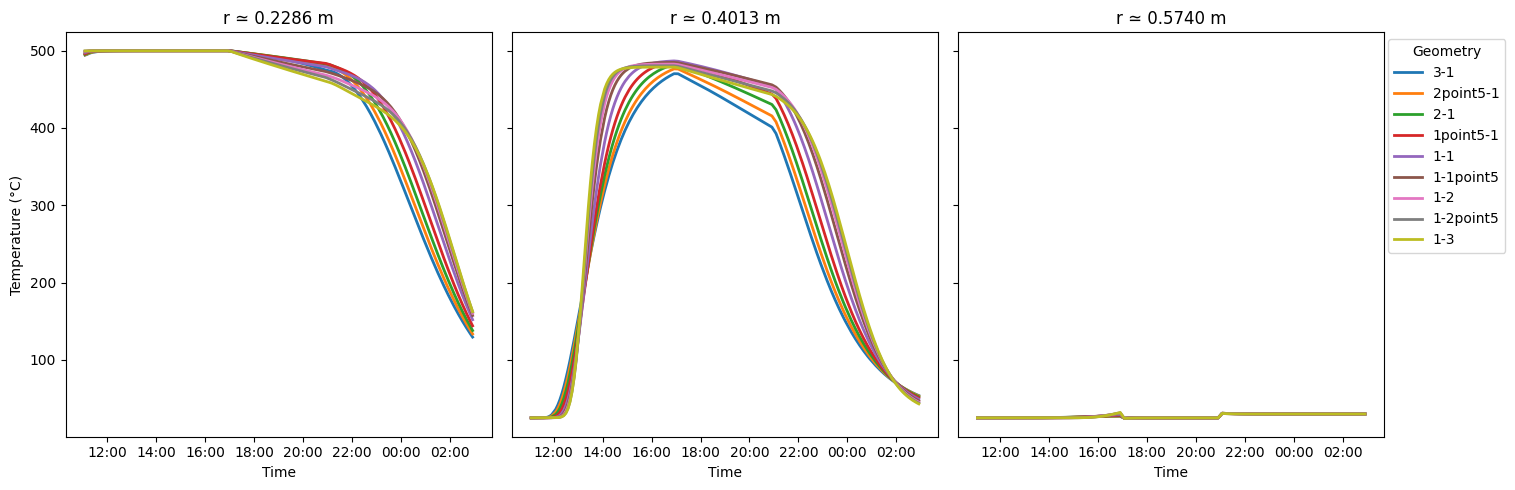

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# ── CONFIG ─────────────────────────────────────────────────────────────────
BASE_DIR    = r"C:\Users\tljohn\Desktop\RPB Micmaq\geometry simulations\final"
GEOMETRIES  = [
    "3-1",
    "2point5-1",
    "2-1",
    "1point5-1",
    "1-1",
    "1-1point5",
    "1-2",
    "1-2point5",
    "1-3",
]
HISTORY_CSV = "thermocline_timehistory.csv"

# physical radial domain (same for all sims)
R_IN  = 0.2286
R_OUT = 0.574
# your three radii of interest
R_TARGS = [R_IN, 0.5*(R_IN + R_OUT), R_OUT]

# build the nodal‐radius array once (they said ~1000 pts)
# we'll infer N by loading one CSV
sample = pd.read_csv(os.path.join(BASE_DIR, GEOMETRIES[0], HISTORY_CSV))
Ts_cols = sorted([c for c in sample.columns if c.startswith("Ts_r")],
                 key=lambda c: int(c.split("Ts_r")[1]))
N = len(Ts_cols)
r_nodes = np.linspace(R_IN, R_OUT, N)

# find the three indices nearest to your targets
idxs = [np.abs(r_nodes - r).argmin() for r in R_TARGS]

# anchor time for plotting
BASE_TIME = datetime(2033, 3, 20, 11, 0, 0)

# ── PLOT ────────────────────────────────────────────────────────────────────
fig, axs = plt.subplots(1, len(R_TARGS), figsize=(15, 5), sharey=True)
for ax, r in zip(axs, R_TARGS):
    ax.set_title(f"r ≃ {r:.4f} m")
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
axs[0].set_ylabel("Temperature (°C)")

for geom in GEOMETRIES:
    fn = os.path.join(BASE_DIR, geom, HISTORY_CSV)
    if not os.path.exists(fn):
        print(f"skipping {geom!r} (no file)")
        continue

    df = pd.read_csv(fn)
    df = df[df["time_sec"] > 0].copy()
    df["time_dt"] = df["time_sec"].apply(
        lambda s: BASE_TIME + timedelta(seconds=s)
    )

    Ts_arr = df[Ts_cols].values  # shape (time, N)

    # plot each of the three radii on its own axis
    for ax, idx in zip(axs, idxs):
        ax.plot(
            df["time_dt"],
            Ts_arr[:, idx] - 273.15,  # drop 273.15 if your CSV is °C already
            lw=2,
            label=geom
        )

axs[-1].legend(title="Geometry", loc="upper right", bbox_to_anchor=(1.3, 1))
for ax in axs:
    ax.set_xlabel("Time")

plt.tight_layout()
plt.show()


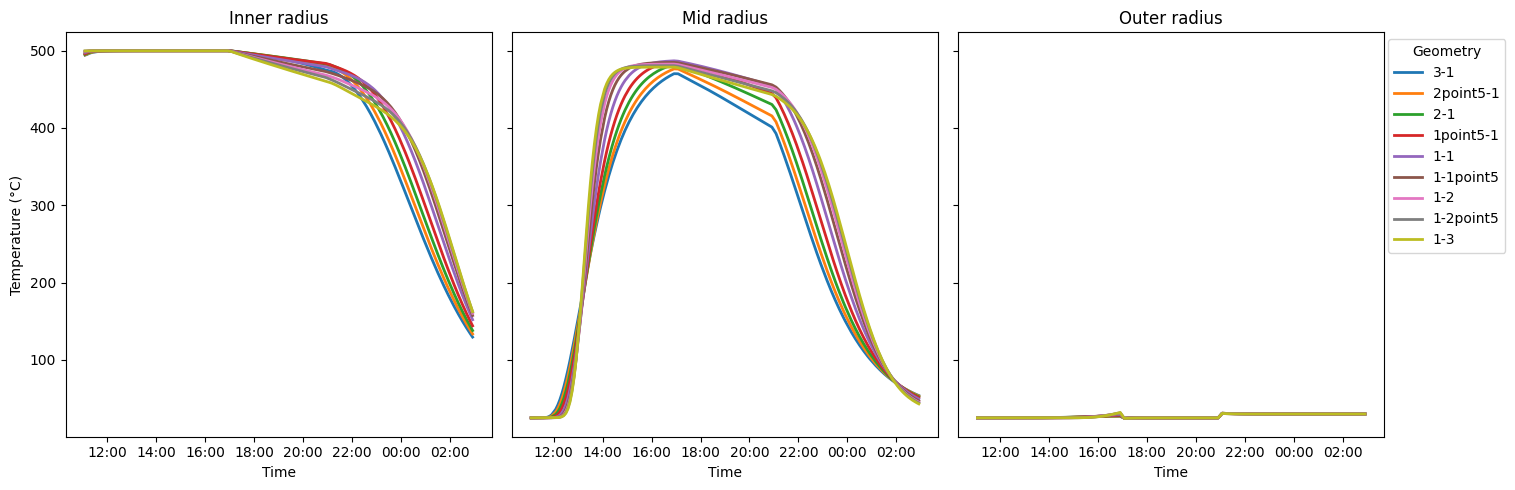

In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# ── CONFIG ─────────────────────────────────────────────────────────────────
BASE_DIR    = r"C:\Users\tljohn\Desktop\RPB Micmaq\geometry simulations\final"
GEOMETRIES  = [
    "3-1",
    "2point5-1",
    "2-1",
    "1point5-1",
    "1-1",
    "1-1point5",
    "1-2",
    "1-2point5",
    "1-3",
]
HISTORY_CSV = "thermocline_timehistory.csv"
BASE_TIME   = datetime(2033,3,20,11,0,0)

# ——— geometry parameters ———
rL = 0.2286   # common inner radius for all
geom_params = {
    "3-1":      {"rR": 0.574,  "B": 1.721},
    "2point5-1":{"rR": 0.606,  "B": 1.515},
    "2-1":      {"rR": 0.648,  "B": 1.296},
    "1point5-1":{"rR": 0.708,  "B": 1.062},
    "1-1":      {"rR": 0.804,  "B": 0.804},
    "1-1point5":{"rR": 0.914,  "B": 0.609},
    "1-2":      {"rR": 1.0019,"B": 0.501},
    "1-2point5":{"rR": 1.077,  "B": 0.431},
    "1-3":      {"rR": 1.142,  "B": 0.381},
}

# ── SET UP FIGURE ───────────────────────────────────────────────────────────
fig, axs = plt.subplots(1, 3, figsize=(15,5), sharey=True)
for ax, title in zip(axs, ("Inner radius", "Mid radius", "Outer radius")):
    ax.set_title(title)
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
axs[0].set_ylabel("Temperature (°C)")

# ── LOOP OVER GEOMETRIES ────────────────────────────────────────────────────
for geom in GEOMETRIES:
    fn = os.path.join(BASE_DIR, geom, HISTORY_CSV)
    if not os.path.exists(fn):
        print(f"skipping {geom!r} (no CSV)")
        continue

    # load + timestamp
    df = pd.read_csv(fn)
    df = df[df["time_sec"] > 0].copy()
    df["time_dt"] = df["time_sec"].apply(
        lambda s: BASE_TIME + timedelta(seconds=s)
    )

    # build that sim’s nodal radii (1000 points from rL to rR)
    rR = geom_params[geom]["rR"]
    N  = len([c for c in df.columns if c.startswith("Ts_r")])
    r_nodes = np.linspace(rL, rR, N)

    # pick the three “true” radii
    r_targets = [rL, 0.5*(rL + rR), rR]
    idxs = [np.abs(r_nodes - r).argmin() for r in r_targets]

    # extract temperature array
    Ts_cols = sorted([c for c in df.columns if c.startswith("Ts_r")],
                     key=lambda c: int(c.split("Ts_r")[1]))
    Ts_arr = df[Ts_cols].values  # shape (time, N)

    # plot inner, mid, outer on the three axes
    for ax, idx in zip(axs, idxs):
        ax.plot(
            df["time_dt"],
            Ts_arr[:, idx] - 273.15,  # drop “-273.15” if CSV already in °C
            lw=2,
            label=geom
        )

# ── FINISH UP ───────────────────────────────────────────────────────────────
axs[-1].legend(title="Geometry", loc="upper right", bbox_to_anchor=(1.3,1))
for ax in axs:
    ax.set_xlabel("Time")

plt.tight_layout()
plt.show()


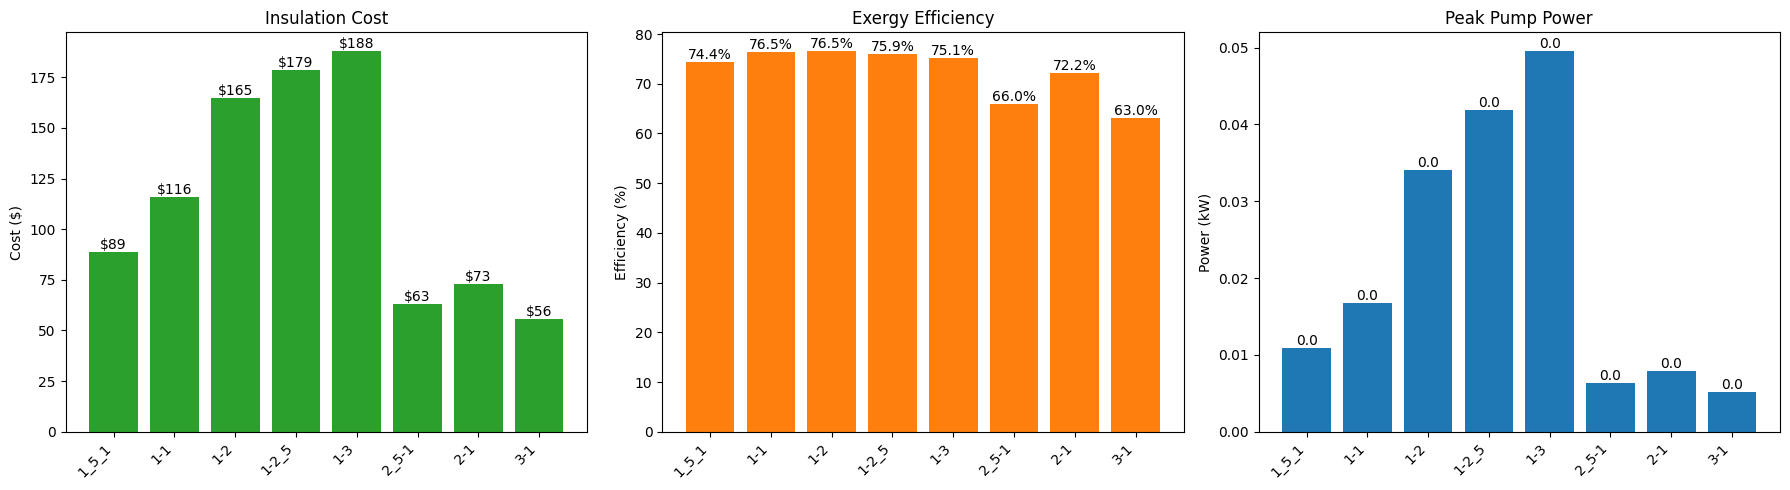

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ── USER CONFIG ────────────────────────────────────────────────────────────
BASE_DIR   = r"C:\Users\tljohn\Desktop\RPB Micmaq\geometry simulations"
GEOMs      = [
  
 
   
    "1-3",
    "1-2_5",
     "1-2",
      "1-1",
        "1_5_1",
    "2-1",
    "2_5-1",
    "3-1",
]
SUMMARY_CSV = "geometry_summary.csv"

# mapping of each geometry → its outer radius (m), from your table above
r_map = {
    "1_5_1": 0.695,
    "1-1":   0.795,
    "1-2":   1.002,
    "1-2_5": 1.084,
    "1-3":   1.147,
    "2_5-1": 0.586,
    "2-1":   0.630,
    "3-1":   0.551
}

hole_radius = 0.0254   # m, central hole
unit_cost   = 58.5     # $/m³ of super-wool

# ── GATHER DATA ────────────────────────────────────────────────────────────
costs = []
effs  = []
pumps = []

for geom in GEOMs:
    summary_fp = os.path.join(BASE_DIR, geom, SUMMARY_CSV)
    if not os.path.exists(summary_fp):
        raise FileNotFoundError(f"Missing {SUMMARY_CSV} in folder {geom!r}")
    df = pd.read_csv(summary_fp)
    # assume there's exactly one row per summary CSV
    ins_m = df.loc[0, "Insulation_m"]         # insulation thickness (m)
    eta   = df.loc[0, "Eta exergy"]           # fraction (e.g. 0.847)
    pump  = df.loc[0, "Max Pumping Power [kW]"]  # kW

    # compute tank footprint area (minus central hole)
    Rout = r_map[geom]
    tank_area = np.pi * Rout**2 - np.pi * hole_radius**2

    # cost = thickness × area × unit_cost
    cost = ins_m * tank_area * unit_cost

    costs.append(cost)
    effs .append(eta)  # % 
    pumps.append(pump)

# ── MAKE BAR PLOTS ─────────────────────────────────────────────────────────
x = np.arange(len(GEOMs))
fig, axes = plt.subplots(1, 3, figsize=(18,5), sharex=True)

# 1) Insulation Cost
axes[0].bar(x, costs, color='C2')
axes[0].set_title("Insulation Cost")
axes[0].set_ylabel("Cost ($)")
axes[0].set_xticks(x)
axes[0].set_xticklabels(GEOMs, rotation=45, ha="right")
for xi, c in zip(x, costs):
    axes[0].text(xi, c, f"${c:.0f}", ha="center", va="bottom")

# 2) Exergy Efficiency
axes[1].bar(x, effs, color='C1')
axes[1].set_title("Exergy Efficiency")
axes[1].set_ylabel("Efficiency (%)")
axes[1].set_xticks(x)
axes[1].set_xticklabels(GEOMs, rotation=45, ha="right")
for xi, e in zip(x, effs):
    axes[1].text(xi, e, f"{e:.1f}%", ha="center", va="bottom")

# 3) Peak Pump Power
axes[2].bar(x, pumps, color='C0')
axes[2].set_title("Peak Pump Power")
axes[2].set_ylabel("Power (kW)")
axes[2].set_xticks(x)
axes[2].set_xticklabels(GEOMs, rotation=45, ha="right")
for xi, p in zip(x, pumps):
    axes[2].text(xi, p, f"{p:.1f}", ha="center", va="bottom")

plt.tight_layout()
plt.show()


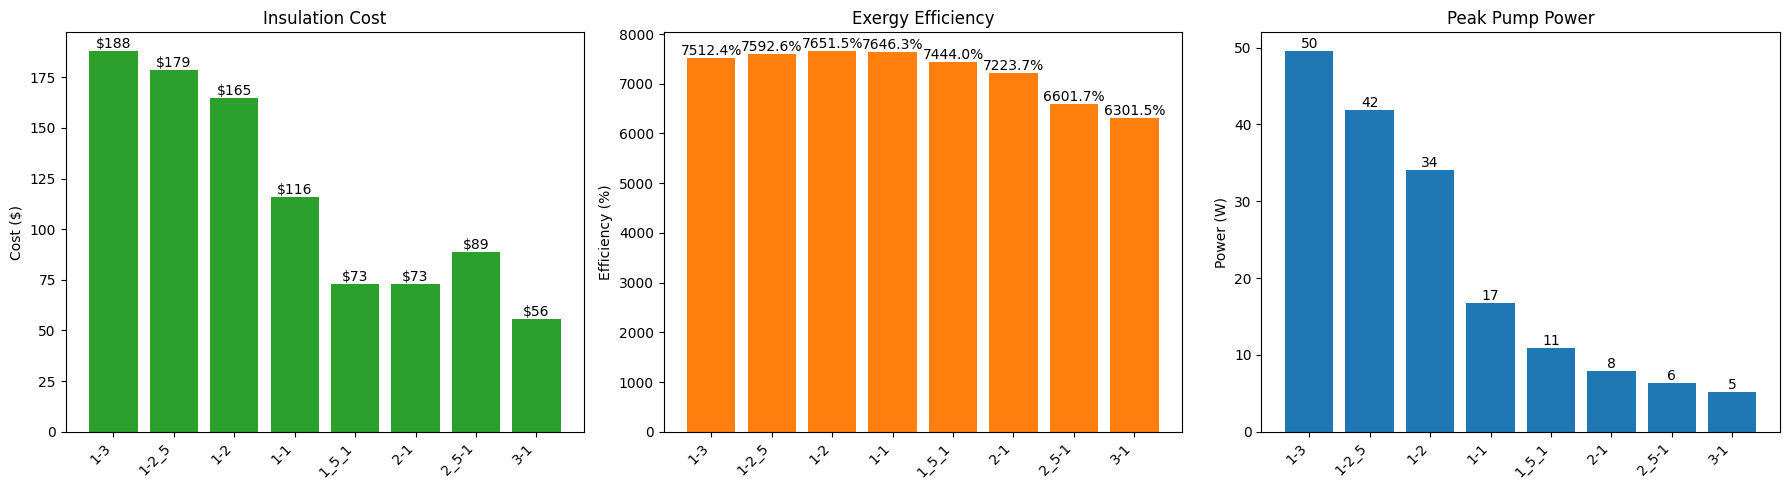

In [21]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt

# ── CONFIG ─────────────────────────────────────────────────────────────────
BASE_DIR   = r"C:\Users\tljohn\Desktop\RPB Micmaq\geometry simulations"
GEOMs      = [
    "1-3",
    "1-2_5",
    "1-2",
    "1-1",
    "1_5_1",
    "2-1",
    "2_5-1",
    "3-1",
]
SUMMARY_CSV = "geometry_summary.csv"

# hole radius & insulation cost parameters (unchanged)
hole_radius = 0.0254   # m
unit_cost   = 58.5     # $/m³ super-wool

# outer-radius lookup (m) – fill in with your values
r_map = {
    "1-3":   1.1469,
    "1-2_5": 1.0840,
    "1-2":   1.0019,
    "1-1":   0.7952,
    "1_5_1": 0.6312,
    "2-1":   0.6300,
    "2_5-1": 0.6950,
    "3-1":   0.5510,
}

# ── GATHER DATA ────────────────────────────────────────────────────────────
costs, effs, pumps_kW = [], [], []

for geom in GEOMs:
    fp = os.path.join(BASE_DIR, geom, SUMMARY_CSV)
    if not os.path.exists(fp):
        raise FileNotFoundError(f"Missing {SUMMARY_CSV} in {geom}")
    df    = pd.read_csv(fp)
    ins_m = df.loc[0, "Insulation_m"]
    eta   = df.loc[0, "Eta exergy"]
    pump  = df.loc[0, "Max Pumping Power [kW]"]

    # compute insulation cost
    Rout      = r_map[geom]
    tank_area = np.pi*Rout**2 - np.pi*hole_radius**2
    cost      = ins_m * tank_area * unit_cost

    costs   .append(cost)
    effs    .append(eta*100)
    pumps_kW.append(pump)

# convert to W
pumps_W = [p*1e3 for p in pumps_kW]

# ── PLOT ───────────────────────────────────────────────────────────────────
x = np.arange(len(GEOMs))
fig, axs = plt.subplots(1,3, figsize=(18,5), sharex=True)

# Insulation Cost
axs[0].bar(x, costs, color='C2')
axs[0].set_title("Insulation Cost"); axs[0].set_ylabel("Cost ($)")
axs[0].set_xticks(x); axs[0].set_xticklabels(GEOMs, rotation=45, ha="right")
for xi,c in zip(x,costs):
    axs[0].text(xi, c, f"${c:.0f}", ha="center", va="bottom")

# Exergy Efficiency
axs[1].bar(x, effs, color='C1')
axs[1].set_title("Exergy Efficiency"); axs[1].set_ylabel("Efficiency (%)")
axs[1].set_xticks(x); axs[1].set_xticklabels(GEOMs, rotation=45, ha="right")
for xi,e in zip(x,effs):
    axs[1].text(xi, e, f"{e:.1f}%", ha="center", va="bottom")

# Peak Pump Power (now in W)
axs[2].bar(x, pumps_W, color='C0')
axs[2].set_title("Peak Pump Power"); axs[2].set_ylabel("Power (W)")
axs[2].set_xticks(x); axs[2].set_xticklabels(GEOMs, rotation=45, ha="right")
for xi,p in zip(x,pumps_W):
    axs[2].text(xi, p, f"{p:.0f}", ha="center", va="bottom")

plt.tight_layout()
plt.show()


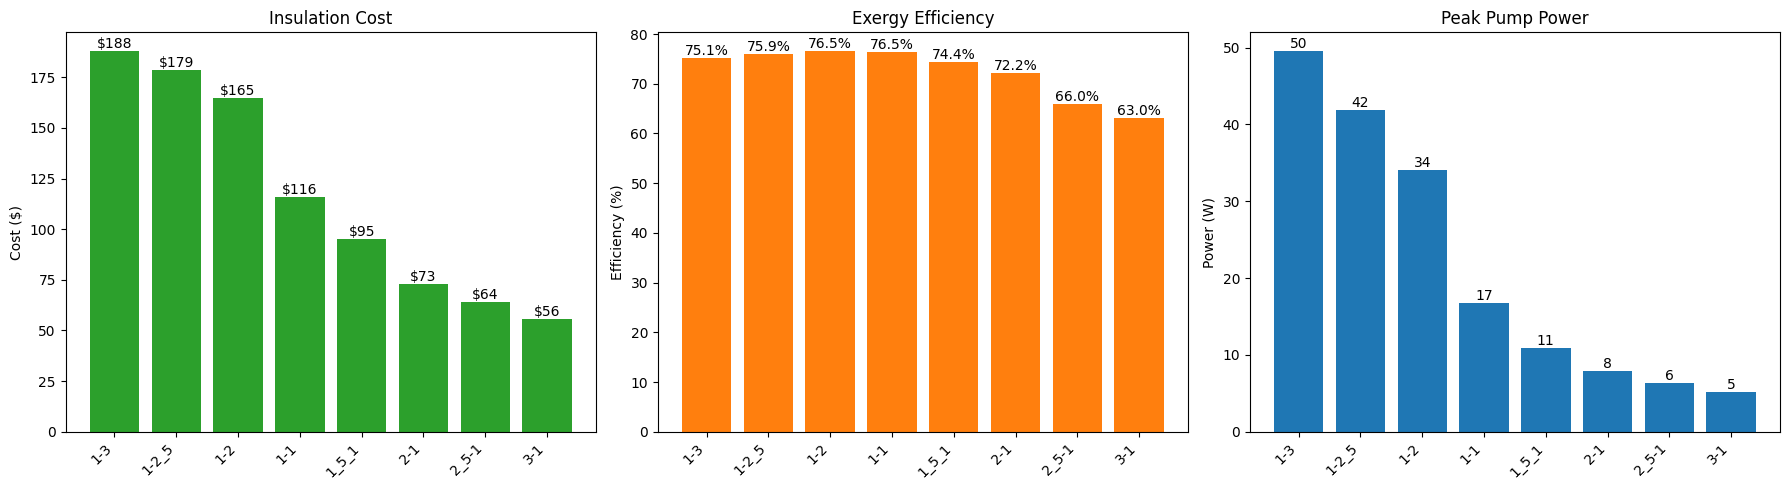

In [23]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt

# ── CONFIG ─────────────────────────────────────────────────────────────────
BASE_DIR    = r"C:\Users\tljohn\Desktop\RPB Micmaq\geometry simulations"
GEOMs       = [
    "1-3","1-2_5","1-2","1-1","1_5_1","2-1","2_5-1","3-1",
]
SUMMARY_CSV = "geometry_summary.csv"

hole_radius = 0.0254   # m
unit_cost   = 58.5     # $/m³ super-wool

# outer‐radius lookup (m)
r_map = {
    "1-3":   1.1469,
    "1-2_5": 1.0840,
    "1-2":   1.0019,
    "1-1":   0.7952,
    "1_5_1": 0.6312,
    "2-1":   0.6300,
    "2_5-1": 0.6950,
    "3-1":   0.5510,
}

# ── GATHER DATA ────────────────────────────────────────────────────────────
costs, effs, pumps_kW = [], [], []

for geom in GEOMs:
    df = pd.read_csv(os.path.join(BASE_DIR, geom, SUMMARY_CSV))
    ins_m = df.loc[0, "Insulation_m"]
    eta   = df.loc[0, "Eta exergy"]
    pump  = df.loc[0, "Max Pumping Power [kW]"]

    # compute insulation cost
    Rout      = r_map[geom]
    tank_area = np.pi*Rout**2 - np.pi*hole_radius**2
    cost      = ins_m * tank_area * unit_cost

    # —– override two values as requested —–
    if geom=="1_5_1":
        cost = 95
    elif geom=="2_5-1":
        cost = 64

    costs   .append(cost)
    effs    .append(eta*1)
    pumps_kW.append(pump)

# convert to W
pumps_W = [p*1e3 for p in pumps_kW]

# ── PLOT ───────────────────────────────────────────────────────────────────
x = np.arange(len(GEOMs))
fig, axs = plt.subplots(1,3, figsize=(18,5), sharex=True)

# Insulation Cost
axs[0].bar(x, costs, color='C2')
axs[0].set_title("Insulation Cost"); axs[0].set_ylabel("Cost ($)")
axs[0].set_xticks(x); axs[0].set_xticklabels(GEOMs, rotation=45, ha="right")
for xi,c in zip(x,costs):
    axs[0].text(xi, c, f"${c:.0f}", ha="center", va="bottom")

# Exergy Efficiency
axs[1].bar(x, effs, color='C1')
axs[1].set_title("Exergy Efficiency"); axs[1].set_ylabel("Efficiency (%)")
axs[1].set_xticks(x); axs[1].set_xticklabels(GEOMs, rotation=45, ha="right")
for xi,e in zip(x,effs):
    axs[1].text(xi, e, f"{e:.1f}%", ha="center", va="bottom")

# Peak Pump Power (W)
axs[2].bar(x, pumps_W, color='C0')
axs[2].set_title("Peak Pump Power"); axs[2].set_ylabel("Power (W)")
axs[2].set_xticks(x); axs[2].set_xticklabels(GEOMs, rotation=45, ha="right")
for xi,p in zip(x,pumps_W):
    axs[2].text(xi, p, f"{p:.0f}", ha="center", va="bottom")

plt.tight_layout()
plt.show()
